In [3]:
pip install --upgrade google-meridian

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import input_data
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 8.6 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [7]:
pddata = pd.read_csv('Hitachi_dataset - FULL_merged_output (5).csv')

In [8]:
kpi_option = ['Total Revenue', 'Quantity']

coord_to_columns = load.CoordToColumns(
    time='date',
    controls=['competitor_trend', 'holidays', 'all_promo', 'CCI', 'seller_discount'],
    kpi='Total Revenue',
    media=[
        'google_impressions',
        'tiktok_impressions',
        'meta_impressions',
        'dv_360_x1_impressions',
    ],
    media_spend=[
        'google_spend',
        'tiktok_spend',
        'meta_spend',
        'dv_360_x1_spend',
    ],
)

In [9]:
correct_media_to_channel = {
    'google_impressions': 'google',
    'tiktok_impressions': 'tiktok',
    'meta_impressions': 'meta',
    'dv_360_x1_impressions': 'dv_360_x1'
}
correct_media_spend_to_channel = {
    'google_spend': 'google',
    'tiktok_spend': 'tiktok',
    'meta_spend': 'meta',
    'dv_360_x1_spend': 'dv_360_x1',
}

In [11]:
loader = load.CsvDataLoader(
    csv_path=f'Hitachi_dataset - FULL_merged_output (5).csv',
    kpi_type='revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel,
)

data = loader.load()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/data/input_data.py:463: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


In [13]:
#functiom to translate the media ROI into a log normal distribution usable by the model prios

def estimate_lognormal_dist(mean, std):
    """
    Reparameterizes the LogNormal distribution in terms of its mean and std.
    Returns mu_log and std_log which can be used to define a LogNormal.
    """
    mu_log = np.log(mean) - 0.5 * np.log((std/mean)**2 + 1)
    std_log = np.sqrt(np.log((std/mean)**2 + 1))
    return mu_log, std_log

roi_mu= 5
roi_sigma= 4.5

roi_mu_log, roi_sigma_log=estimate_lognormal_dist(roi_mu, roi_sigma)
print(roi_mu_log, roi_sigma_log)

pddata = pd.read_csv('Hitachi_dataset - FULL_merged_output (5).csv')

# setting priors based on spend share
total_spend= pddata['google_spend'].sum()+pddata['meta_spend'].sum()+pddata['tiktok_spend'].sum()+pddata['dv_360_x1_spend'].sum()
priors={'mu':[], 'sigma':[]}
for i in ['google_spend', 'meta_spend', 'tiktok_spend', 'dv_360_x1_spend']:
  spend_share=(pddata[i].sum()/total_spend)*2
  roi_sigma=roi_mu*spend_share
  mu , sigma= estimate_lognormal_dist(roi_mu, roi_sigma)
  priors['mu'].append(mu)
  priors['sigma'].append(sigma)

print(priors)

roi_mu=priors['mu']
roi_sigma=priors['sigma']
print(roi_mu)


1.3127744897952331 0.7702771223902047
{'mu': [np.float64(1.5172346544216266), np.float64(1.5882307456076374), np.float64(1.6093826373303226), np.float64(1.0995742107093482)], 'sigma': [np.float64(0.4294257980430928), np.float64(0.2059474050648024), np.float64(0.010514285879484764), np.float64(1.0098155294158948)]}
[np.float64(1.5172346544216266), np.float64(1.5882307456076374), np.float64(1.6093826373303226), np.float64(1.0995742107093482)]


In [14]:
# Convert numpy float64 values to TensorFlow float32 tensors
roi_mu = [tf.convert_to_tensor(m, dtype=tf.float32) for m in roi_mu]
roi_sigma = [tf.convert_to_tensor(s, dtype=tf.float32) for s in roi_sigma]

# Build media channel arguments
build_media_channel_args = data.get_paid_media_channels_argument_builder()

# Pass the converted tensors
roi_m = build_media_channel_args(
    google=(roi_mu[0], roi_sigma[0]),
    meta=(roi_mu[1], roi_sigma[1]),
    tiktok=(roi_mu[2], roi_sigma[2]),
    dv_360_x1=(roi_mu[3], roi_sigma[3]),
)

# Unpack into separate mu and sigma tensors
roi_m_mu, roi_m_sigma = zip(*roi_m)

# Convert to TensorFlow tensors
roi_m_mu = tf.stack(roi_m_mu)
roi_m_sigma = tf.stack(roi_m_sigma)

# Create prior distribution
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_m_mu, roi_m_sigma, name=constants.ROI_M),
)

In [15]:
np.random.seed(1)
test_pct = 0.2  # 20% holdout
n_times = len(data.time)

# Create a 1D boolean array of length n_times
holdout_id = np.full(n_times, False)
holdout_indices = np.random.choice(n_times, int(np.round(test_pct * n_times)), replace=False)
holdout_id[holdout_indices] = True

# Pass it into the model spec
model_spec = spec.ModelSpec(
    prior=prior,
    holdout_id=holdout_id
)


In [16]:
#%%time

mmm = model.Meridian(input_data=data, model_spec=model_spec)
mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time

# ... (rest of your imports and code) ...

with tqdm(total=5*1000, desc="Training Progress") as pbar:  # Total iterations
    def update_progress(current_iteration, total_iterations):
        pbar.update(current_iteration)  # Update the progress bar

    # Remove progress_callback from the sample_posterior call
    mmm.sample_posterior(
        n_chains=5,
        n_adapt=500,
        n_burnin=500,
        n_keep=1000,
        parallel_iterations=100,
        # progress_callback=update_progress  # Remove this line
    )
    # Manually update progress bar after sampling
    pbar.update(5 * 1000)

#n_chains: Markov Chain Monte Carlo (MCMC) indipendent chains
#n_adapt: number of initial samples used to tune the sampling algorithm for better performance
#n_burnin: number of initial samples from each chain that are discarded
#n_keep: number of samples to keep from each chain after the burn-in phase. These samples represent the posterior distribution of the model parameters and are used for inference.

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
I0000 00:00:1751256985.384941  310392 service.cc:148] XLA service 0x1537c5500 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751256985.386250  310392 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1751256985.589441  310392 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:912: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-06-30 11:17:14.315900: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-30 11:17:15.160984: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1751257035.885761  310392 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


In [17]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

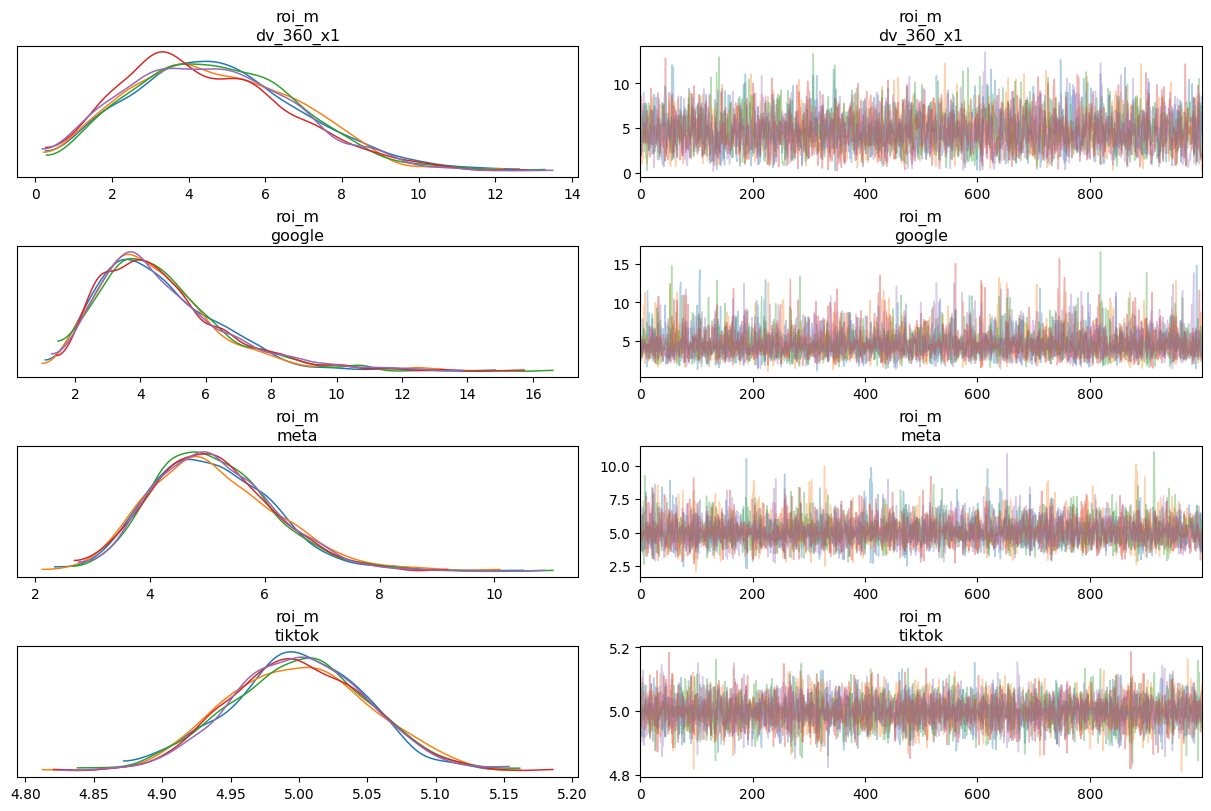

In [18]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [19]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_prior_and_posterior_distribution()

alt.FacetChart(...)

In [20]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:583: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [21]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:882: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/visualizer.py:1629: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,dv_360_x1,prior,"147,092,912",20%,"$1,558,208",66.6%,$11,"$7,859,050 ($853,862, $22,539,298)","6.0% (0.7%, 17.3%)","5.0 (0.5, 14.5)","0.05 (0.01, 0.15)","2.1 (0.2, 6.0)","$0.3 ($0.1, $1.8)"
1,dv_360_x1,posterior,"147,092,912",20%,"$1,558,208",66.6%,$11,"$7,227,618 ($2,175,948, $13,219,003)","6.0% (1.8%, 11.0%)","4.6 (1.4, 8.5)","0.05 (0.01, 0.09)","1.8 (0.4, 3.8)","$0.2 ($0.1, $0.7)"
2,google,prior,"377,252,800",51%,"$526,693",22.5%,$1,"$2,633,137 ($1,139,405, $5,051,094)","2.0% (0.9%, 3.9%)","5.0 (2.2, 9.6)","0.01 (0.00, 0.01)","2.2 (0.8, 4.4)","$0.2 ($0.1, $0.5)"
3,google,posterior,"377,252,800",51%,"$526,693",22.5%,$1,"$2,444,298 ($1,145,714, $4,374,200)","2.0% (1.0%, 3.6%)","4.6 (2.2, 8.3)","0.01 (0.00, 0.01)","1.9 (0.7, 3.8)","$0.2 ($0.1, $0.5)"
4,meta,prior,"199,569,088",27%,"$243,623",10.4%,$1,"$1,245,320 ($844,771, $1,731,718)","1.0% (0.6%, 1.3%)","5.1 (3.5, 7.1)","0.01 (0.00, 0.01)","2.1 (0.9, 3.5)","$0.2 ($0.1, $0.3)"
5,meta,posterior,"199,569,088",27%,"$243,623",10.4%,$1,"$1,245,430 ($863,412, $1,700,252)","1.0% (0.7%, 1.4%)","5.1 (3.5, 7.0)","0.01 (0.00, 0.01)","2.1 (1.0, 3.3)","$0.2 ($0.1, $0.3)"
6,tiktok,prior,"10,813,859",1%,"$12,306",0.5%,$1,"$61,584 ($60,455, $62,642)","0.0% (0.0%, 0.0%)","5.0 (4.9, 5.1)","0.01 (0.01, 0.01)","2.0 (1.1, 2.9)","$0.2 ($0.2, $0.2)"
7,tiktok,posterior,"10,813,859",1%,"$12,306",0.5%,$1,"$61,527 ($60,510, $62,539)","0.1% (0.1%, 0.1%)","5.0 (4.9, 5.1)","0.01 (0.01, 0.01)","2.0 (1.1, 2.8)","$0.2 ($0.2, $0.2)"
8,All Channels,prior,"734,728,704",100%,"$2,340,830",100.0%,$3,"$11,799,086 ($4,294,311, $27,124,802)","9.0% (3.3%, 20.8%)","5.0 (1.8, 11.6)","nan (nan, nan)","nan (nan, nan)","$0.3 ($0.1, $0.5)"
9,All Channels,posterior,"734,728,704",100%,"$2,340,830",100.0%,$3,"$10,978,864 ($5,658,316, $16,977,774)","9.1% (4.7%, 14.1%)","4.7 (2.4, 7.3)","nan (nan, nan)","nan (nan, nan)","$0.2 ($0.1, $0.4)"


In [22]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:583: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,evaluation_set,value
0,R_Squared,national,Train,0.799463
1,R_Squared,national,Test,0.723748
2,R_Squared,national,All Data,0.782783
3,MAPE,national,Train,0.586519
4,MAPE,national,Test,1.409281
5,MAPE,national,All Data,0.748480
6,wMAPE,national,Train,0.292529
7,wMAPE,national,Test,0.447347
8,wMAPE,national,All Data,0.320441


In [25]:
filepath = './output'  # or any local directory you want
start_date = '2022-12-26'
end_date = '2025-05-26'

# Make sure the directory exists
import os
os.makedirs(filepath, exist_ok=True)

mmm_summarizer.output_model_results_summary('summary_output.html', filepath, start_date, end_date)

# To display in VS Code Jupyter notebook output
#from IPython.display import HTML
#HTML(filename=os.path.join(filepath, 'summary_output.html'))


/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:3096: UserWarning: Effectiveness is not reported because it does not have a clear interpretation by time period.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:882: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)


In [26]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)

build_channel_args = mmm.input_data.get_paid_channels_argument_builder()

optimization_results = budget_optimizer.optimize(
      selected_times=('2022-12-26', '2025-05-26'),
)

/var/folders/j5/rxb3ttd52vj7syxs52r9z_zm0000gn/T/ipykernel_8685/2642963883.py:5: DeprecationWarning: `selected_times` is deprecated. Please use `start_date` and `end_date` instead.
  optimization_results = budget_optimizer.optimize(


In [27]:
optimization_results.output_optimization_summary('optimization_output.html', filepath)
#IPython.display.HTML(filename='/content/drive/MyDrive/optimization_output.html')